In [1]:
from pathlib import Path
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import morphology
from skimage import transform
from skimage import draw
from skimage import util
from skimage import measure
from skimage import exposure

import cv2
import re
import numpy as np
import itertools as it


from collections import Counter
# %matplotlib qt

In [32]:
pp = Path('../data/partial_results/1/2_kontury_wyrazow_na_fragmencie/3.png')
img = io.imread(pp)
img_rot = transform.rotate(img, 50,  resize=True)
img_rot_inv = transform.rotate(img_rot, -50,  resize=True)

(1290, 910)


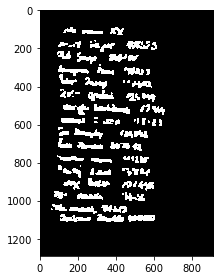

In [33]:
print(img.shape)
io.imshow(img)

(1526, 1573)


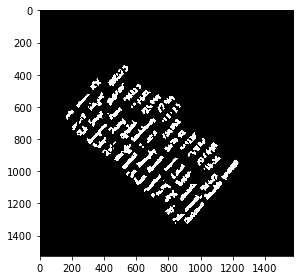

In [34]:
print(img_rot.shape)
io.imshow(img_rot)

(1291, 910)


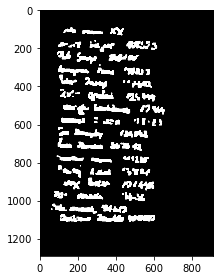

In [46]:
diff = (np.array(img_rot_inv.shape) - np.array(img.shape))/2
new = img_rot_inv[int(diff[0]):-int(diff[0]), int(diff[1]):-int(diff[1])]
print(new.shape)
io.imshow(new)

In [36]:
print(img.shape)
print(img_rot.shape)
print(img_rot_inv.shape)

(1290, 910)
(1526, 1573)
(2185, 2180)


# V1 - AKTUALNE

### Pomocnicze

In [2]:

# rect_points - (start_point, end_point), where p0 is top-left corner, p1 is down-right corner
def euclidean_distance(p1, p2):
        return pow(pow(p1[0]-p2[0],2)+pow(p1[1]-p2[1],2),0.5)


def sort_regions_by_area(regions, descending=True):     
    def func(region):
        return region.area

    regions = sorted(regions, key=func, reverse=descending)
    return regions

def get_binary_image_with_digits(word_image):
    # Multio-Otsu dzieli obraz na 3 klasy o różnych jasnościach.
    thresholds = filters.threshold_multiotsu(word_image, classes=3)

    # Regions - to obraz, który ma wartości od 0 do 2. 
    # Wartość odpowiada regionowi, do którego należey dany piksel.
    otsu_regions = np.digitize(word_image, bins=thresholds)

    # Jeden z wykrytych regionów odpowiadał w większości jasności kratki, więc go usuwam.
    # Region trzeba traktować jako jakiś przedział wartości jasności w obrazie.
    image_removed_otsu_region = word_image*util.invert((otsu_regions == 1))

    # Po ponownym wykryciu regionów, jeden z nich pasował do cyfr więc użyłem go licząc, że są to cyfry.
    thresholds = filters.threshold_multiotsu(image_removed_otsu_region, classes=3)
    otsu_regions = np.digitize(word_image, bins=thresholds)
    image_digits = (otsu_regions==0)
    
    return image_digits

def get_digits_regions(image_digits):
    # Tutaj region to już chodzi o podobne jasności pikseli w sąsiedztwie.
    label_image = measure.label(image_digits)
    regions = measure.regionprops(label_image)
    
    # usuwanie regionów, które są zbyt szerokie na liczbę (usuwa wykryte poziome linie kratki)
    # źle działa dla 2_1, cyfra 5 jest zbyt duża
#     width = image_digits.shape[1] 
#     regions_width = [(np.max(reg.coords[:, 1]) - np.min(reg.coords[:, 1])) for reg in regions]
#     regions = [reg for i, reg in enumerate(regions) if regions_width[i] < width/5]

    print("liczba wykrytych regionów (cyfr): ", len(regions))
    
    
    return regions


def remove_overlapped_regions(regions_as_rect_points):
    # usunięcie regionów zbytnio nakładajacych się na siebie, prawdopodobnie cyfra została podzielona na górę-dół
    
    regions_list_with_key = []
    for i, reg in enumerate(regions_as_rect_points):
        regions_list_with_key.append([i, reg])
    
    valid_regions = []
    invalid_regions_keys = []
    l1 = regions_list_with_key[0:]
    l2 = regions_list_with_key[1:]
    for reg1_dict, reg2_dict in zip(l1, l2): 
        reg1_key, reg1 = reg1_dict
        reg2_key, reg2 = reg2_dict
        
        if reg1_key in invalid_regions_keys:
            continue

        reg1_start_point, reg1_end_point = reg1
        reg2_start_point, reg2_end_point = reg2
        
        diff = reg2_start_point[1] - reg1_end_point[1] 
        if diff < 0: # jeżeli regiony oddalone o mniej niż X pikseli to połącz w jeden
            new_start_point, new_end_point = combine_two_overlapping_regions(reg1, reg2)
                
            valid_regions.append([new_start_point, new_end_point])              
            invalid_regions_keys.append(reg1_key)
            invalid_regions_keys.append(reg2_key)

    
    for key, reg in regions_list_with_key:
        if key not in invalid_regions_keys:
            valid_regions.append(reg)
            
    return valid_regions

def combine_two_overlapping_regions(reg1, reg2):
    reg1_start_point, reg1_end_point = reg1
    reg2_start_point, reg2_end_point = reg2
        
    new_start_point = []
    new_end_point = []

    if reg1_start_point[0] < reg2_start_point[0]:
        new_start_point.append(reg1_start_point[0])
    else:
        new_start_point.append(reg2_start_point[0])
    if reg1_start_point[1] < reg2_start_point[1]:
        new_start_point.append(reg1_start_point[1])
    else:
        new_start_point.append(reg2_start_point[1])           

    if reg1_end_point[0] > reg2_end_point[0]:
        new_end_point.append(reg1_end_point[0])
    else:
        new_end_point.append(reg2_end_point[0])
    if reg1_end_point[1] > reg2_end_point[1]:
        new_end_point.append(reg1_end_point[1])
    else:
        new_end_point.append(reg2_end_point[1])
        
    return new_start_point, new_end_point

def get_list_of_rectangle_points(regions):
    rect_points = [get_two_points_to_create_rectangle_from_region(reg) for reg in regions]
    
    # usuwanie bardzo małych wykrytych obszarów
    def func_area(points):
        start_point, end_point = points
        width = abs(end_point[1]-start_point[1])
        height = abs(end_point[0]-start_point[0])
        return width*height
    
    rect_points_area = [func_area(reg) for reg in rect_points]
    rect_points = [reg for i, reg in enumerate(rect_points) if rect_points_area[i] > 20]
    
    # sortowanie obszarów, biegnących od lewej do prawej - aby cyfry były po kolei
    def func(points):
        p0, p1 = points
        return (p0[1] + p1[1])/2   
    rect_points_sorted_by_distance_to_start_of_horizontal_axis = sorted(rect_points, key=func)    
    rect_points = remove_overlapped_regions(rect_points_sorted_by_distance_to_start_of_horizontal_axis)
    rect_points = sorted(rect_points, key=func) 
    rect_points = remove_overlapped_regions(rect_points)
    rect_points = sorted(rect_points, key=func) 
    
#     rect_points = rect_points_sorted_by_distance_to_start_of_horizontal_axis # TODO do usunięcia

#     l1 = rect_points[0:]
#     l2 = rect_points[1:]
#     for reg1, reg2 in zip(l1, l2):
#         half_diff = int((reg2[0][1] - reg1[1][1])/2)
#         reg1[1][1] += half_diff
#         reg2[0][1] -= half_diff
        
    print("liczba wykrytych regionów ostatecznie (cyfr): ", len(rect_points))
    print(rect_points)
    return rect_points
        

def get_two_points_to_create_rectangle_from_region(region):
    height_min = np.min(region.coords[:, 0])
    width_min = np.min(region.coords[:, 1])
    height_max = np.max(region.coords[:, 0])
    width_max = np.max(region.coords[:, 1])
    
    return [[height_min, width_min], [height_max, width_max]]

def scale_digit_image(image, scale=28):
    (h, w) = image.shape
    
    if abs(h-w) < 2:
        image = transform.resize(image, (scale,scale))
        return image
    if h > w: 
        half_diff = int((h-w)/2) # zakładamy, że jednak zawsze cyfra jest wyższa niż szersza
        
        # left border
        new_image_left_border = np.full((h,w+half_diff), fill_value=0, dtype=np.uint8)
        new_image_left_border[:,half_diff:] = image
        image = new_image_left_border
              
        # right border
        fill_value = (h-w) - 2*half_diff
        (h, w) = image.shape
        new_image_right_border = np.full((h,w+half_diff+fill_value), fill_value=0, dtype=np.uint8)
        new_image_right_border[:,:-half_diff-fill_value] = image
        image = new_image_right_border
        
    else:
        half_diff = int((w-h)/2) # zakładamy, że jednak zawsze cyfra jest wyższa niż szersza

        # bottom border  
        new_image_bot_border = np.full((h+half_diff,w), fill_value=0, dtype=np.uint8)
        new_image_bot_border[:-half_diff,:] = image
        image = new_image_bot_border

        # top border
        fill_value = (w-h) - 2*half_diff
        (h, w) = image.shape
        new_image_top_border = np.full((h+half_diff+fill_value,w), fill_value=0, dtype=np.uint8)
        new_image_top_border[half_diff+fill_value:,:] = image
        image = new_image_top_border
    
    image = transform.resize(image, (scale,scale)) # to zmienia na float8
    image = util.img_as_bool(image) # jak tego nie użyłem to po zmianie na uint8 (czyli akcja niżej) 
                                    # miałem wartości inne niż 0 i 255 (np. 254)
    image = util.img_as_ubyte(image) # nie mogę zapisywać obrazów typu bool, czyli takich jak wyżej, więc zmiana na uint8
    
    return image


### Główny program

In [9]:
source_path = Path('../data/partial_results/wyciete_indeksy')

save_path = Path('../data/partial_results/wyciete_indeksy_wykryte_cyfry')
save_path.mkdir(parents=True, exist_ok=True)

images_directories = source_path.glob("*")

detections = []
for directory in images_directories:
    images_paths = directory.glob("*.png")
    
    # Utworzenie katalogu konkretnego zdjęcia.
    number_of_image = re.search('[0-9]+', directory.stem)[0]
    image_directory = save_path / number_of_image
    image_directory.mkdir(parents=True, exist_ok=True)
    
    for word_image_path in list(images_paths):
#         word_image_path = Path('../data/partial_results/wyciete_indeksy/2/1.png') # TODO - do usunięcia
        print(word_image_path) # TODO - do usunięcia
        
        # Utworzenie katalogu konkretnego indeksu.
        number_of_word = re.search('[0-9]+', word_image_path.stem)[0]
        word_directory = image_directory / str(number_of_word)
        word_directory.mkdir(parents=True, exist_ok=True)
    
        # Wczytanie obrazu
        word_image_org = io.imread(word_image_path)
        word_image = word_image_org.copy()
        word_image = color.rgb2gray(word_image)
        word_image = filters.gaussian(word_image)
        
        # Rozciąganie jasności obrazu.
        p2, p98 = np.percentile(word_image, (2, 98))
        word_image = exposure.rescale_intensity(word_image, in_range=(p2, p98))

        image_digits = get_binary_image_with_digits(word_image)

        regions = get_digits_regions(image_digits)    
        rect_points_sorted_by_distance_to_start_of_horizontal_axis = get_list_of_rectangle_points(regions)
        detections.append(len(rect_points_sorted_by_distance_to_start_of_horizontal_axis)) # TODO usunąć
                    
        word_image = color.gray2rgb(word_image)  
        image_digits = util.img_as_ubyte(image_digits)
        temp_image = word_image_org.copy()
        temp_image = color.gray2rgb(temp_image)
        for index_digit, (start_point, end_point) in enumerate(rect_points_sorted_by_distance_to_start_of_horizontal_axis):           
            # Narysowanie prostokąta wokół cyfry.
            rr, cc = draw.rectangle_perimeter(start_point, end_point, shape=temp_image.shape)         
            temp_image[rr, cc] = (255,0+index_digit*30,0+index_digit*30)
            
                
#             for coord in region.coords:
#                 height = coord[0]
#                 width = coord[1]
#                 temp_image[(height,width)] = (255,0,0)
            
            # Wycięcie cyfry
            one_digit =  image_digits[:, start_point[1]:end_point[1]+1]
            one_digit = scale_digit_image(one_digit, scale=28)
            io.imsave(arr=one_digit, fname=word_directory / '{}.png'.format(index_digit))
            
        io.imsave(arr=temp_image, fname=word_directory / 'index.png')
#         io.imshow(temp_image)
#         break
#     break

stats = Counter(detections)  
all_cases = sum(stats.values())
print("{}/{} == {}".format(stats[6], all_cases , (stats[6]/all_cases)))
print(stats)

..\data\partial_results\wyciete_indeksy_2\1\2.png
liczba wykrytych regionów (cyfr):  14
liczba wykrytych regionów ostatecznie (cyfr):  7
[[[14, 19], [39, 36]], [[16, 37], [51, 58]], [[43, 69], [50, 86]], [[27, 104], [56, 119]], [[25, 122], [39, 126]], [[22, 138], [43, 152]], [[26, 166], [56, 179]]]
..\data\partial_results\wyciete_indeksy_2\1\3.png
liczba wykrytych regionów (cyfr):  9
liczba wykrytych regionów ostatecznie (cyfr):  6
[[[8, 26], [39, 30]], [[10, 45], [36, 51]], [[25, 63], [35, 72]], [[7, 97], [39, 110]], [[19, 122], [37, 133]], [[9, 154], [40, 162]]]
..\data\partial_results\wyciete_indeksy_2\1\4.png
liczba wykrytych regionów (cyfr):  11
liczba wykrytych regionów ostatecznie (cyfr):  6
[[[21, 22], [46, 27]], [[20, 47], [43, 59]], [[23, 77], [44, 86]], [[27, 95], [50, 110]], [[17, 127], [30, 137]], [[18, 144], [45, 172]]]
..\data\partial_results\wyciete_indeksy_2\1\5.png
liczba wykrytych regionów (cyfr):  20
liczba wykrytych regionów ostatecznie (cyfr):  6
[[[9, 16], [47, 4

<ipython-input-9-0cd761a71c3b>:44: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  temp_image = color.gray2rgb(temp_image)
<ipython-input-9-0cd761a71c3b>:59: UserWarning: ..\data\partial_results\wyciete_indeksy_wykryte_cyfry_2\1\2\4.png is a low contrast image
  io.imsave(arr=one_digit, fname=word_directory / '{}.png'.format(index_digit))
<ipython-input-9-0cd761a71c3b>:59: UserWarning: ..\data\partial_results\wyciete_indeksy_wykryte_cyfry_2\1\5\2.png is a low contrast image
  io.imsave(arr=one_digit, fname=word_directory / '{}.png'.format(index_digit))


Jakie problemy? przykład 3_5 - obraz 3, indeks 5
- DONE dzieli liczby jak 2 czy 3 w połowie na dwie części góra i dół - DONE prawie - jeżeli podzieli liczbę na pół i te dwie połowy wykryje jako osobne regiony to mamy dwa razy 2 (bo wycinamy całą wysokość obrazu zawsze) - przykład 3_5
- DONE trzeba coś wymyślić, zby wyeliminowac wykrywanie zbyt małych regionów (które nie są liczbami)
- DONE jak jest bardzo cienka cyfra, np. jedynka w kształcie pojedynczej kreski to po przeskalowaniu wychodzi coś dziwnego, przykład 9_5
- DONE - 10_7 - dziwny przypadek, jakoś wymyślić żeby regiony mogły być tylko obok siebie
- DONE - problem jak siedem cyfr 24_7
- DONE - nie włączone - może coś zrobić, aby regiony stykały się między sobą, region  jednej cyfry styka się z regionem drugiej cyfry


- cyfry zbyt blisko siebie, aż się prawie dotykają np. zdjęcie 1, ostatni wiersz cyfry 78
- czasami jasność kratki i cyfr jest tak bliska siebie, że cyfry łączą się poprzez kratkę i wykrywa dwie cyfry jako jeden region, np. 1_11 (82), 2_8 (23)
- wycinanie indeksów - może przydałoby się dodać lekki margines na około
- przy wycinaniu cyfr też dodać lekki margines
- potrafi 4 podzielić na 2 części lewo-prawo 16_0

In [12]:
all_cases = sum(stats.values())
print("{}/{} == {}".format(stats[5], all_cases , (stats[5]/all_cases)))
print(stats)

16/628 == 0.025477707006369428
Counter({1: 118, 2: 85, 3: 42, 20: 24, 18: 21, 23: 19, 17: 17, 21: 17, 25: 17, 8: 16, 5: 16, 4: 16, 22: 15, 26: 14, 24: 13, 13: 12, 14: 12, 16: 12, 19: 12, 12: 11, 11: 11, 29: 11, 7: 10, 6: 9, 27: 9, 15: 8, 28: 8, 31: 7, 30: 7, 9: 7, 10: 6, 33: 5, 34: 5, 35: 4, 32: 3, 36: 2, 38: 2, 37: 1, 65: 1, 41: 1, 39: 1, 93: 1})


# Nieużywane

In [3]:
# zmienione v2
import cv2
source_path = Path('../data/partial_results/wyciete_indeksy')

save_path = Path('../data/partial_results/wyciete_indeksy_zmienione_v2')
save_path.mkdir(parents=True, exist_ok=True)

images_directories = source_path.glob("*")
for directory in images_directories:
    images_paths = directory.glob("*.png")
    number_of_image = re.search('[0-9]+', directory.stem)[0]
    save_directory = save_path / number_of_image
    save_directory.mkdir(parents=True, exist_ok=True)
    
    for image_path in list(images_paths):     
#         number_of_word = re.search('[0-9]+', image_path.stem)[0]
        print(image_path)
        img = io.imread(image_path)
        img = color.rgb2gray(img)
        
        # img = filters.gaussian(img)
        # Contrast stretching
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))

        # thresh = filters.threshold_otsu(img, 3)
        # img = img > thresh
        # img = morphology.opening(img, morphology.disk(1))


        img = util.img_as_ubyte(img)
        img = cv2.Canny(image=img, threshold1=800, threshold2=1000)

        img = morphology.closing(img, morphology.disk(2))


        label_img = measure.label(img)
        regions = measure.regionprops(label_img)

        def func(region):
            return region.area

        img = color.gray2rgb(img)
        regions = sorted(regions, key=func, reverse=True)
        print(len(regions))
        for index_digit, region in enumerate(regions[:6]):
            height_min = np.min(region.coords[:, 0])
            width_min = np.min(region.coords[:, 1])
            height_max = np.max(region.coords[:, 0])
            width_max = np.max(region.coords[:, 1])
            rr, cc = draw.rectangle_perimeter((height_min, width_min), (height_max, width_max), shape=img.shape)         
            img[rr, cc] = (255,0,0)
        
        io.imsave(arr=img, fname=save_directory / "{}.png".format(number_of_word) )
        

# io.imshow(img)


..\data\partial_results\wyciete_indeksy\1\0.png
9
..\data\partial_results\wyciete_indeksy\1\1.png
19
..\data\partial_results\wyciete_indeksy\1\10.png
6
..\data\partial_results\wyciete_indeksy\1\11.png
18
..\data\partial_results\wyciete_indeksy\1\12.png
7
..\data\partial_results\wyciete_indeksy\1\2.png
7
..\data\partial_results\wyciete_indeksy\1\3.png
6
..\data\partial_results\wyciete_indeksy\1\4.png
8
..\data\partial_results\wyciete_indeksy\1\5.png
9
..\data\partial_results\wyciete_indeksy\1\6.png
5
..\data\partial_results\wyciete_indeksy\1\7.png
6
..\data\partial_results\wyciete_indeksy\1\8.png
7
..\data\partial_results\wyciete_indeksy\1\9.png
5
..\data\partial_results\wyciete_indeksy\10\0.png
5
..\data\partial_results\wyciete_indeksy\10\1.png
14
..\data\partial_results\wyciete_indeksy\10\10.png
6
..\data\partial_results\wyciete_indeksy\10\2.png
8
..\data\partial_results\wyciete_indeksy\10\3.png
8
..\data\partial_results\wyciete_indeksy\10\4.png
8
..\data\partial_results\wyciete_indek

..\data\partial_results\wyciete_indeksy\19\15.png
6
..\data\partial_results\wyciete_indeksy\19\16.png
9
..\data\partial_results\wyciete_indeksy\19\17.png
4
..\data\partial_results\wyciete_indeksy\19\18.png
3
..\data\partial_results\wyciete_indeksy\19\19.png
4
..\data\partial_results\wyciete_indeksy\19\2.png
6
..\data\partial_results\wyciete_indeksy\19\20.png
8
..\data\partial_results\wyciete_indeksy\19\21.png
8
..\data\partial_results\wyciete_indeksy\19\22.png
6
..\data\partial_results\wyciete_indeksy\19\3.png
3
..\data\partial_results\wyciete_indeksy\19\4.png
8
..\data\partial_results\wyciete_indeksy\19\5.png
7
..\data\partial_results\wyciete_indeksy\19\6.png
9
..\data\partial_results\wyciete_indeksy\19\7.png
8
..\data\partial_results\wyciete_indeksy\19\8.png
6
..\data\partial_results\wyciete_indeksy\19\9.png
9
..\data\partial_results\wyciete_indeksy\2\0.png
15
..\data\partial_results\wyciete_indeksy\2\1.png
13
..\data\partial_results\wyciete_indeksy\2\10.png
7
..\data\partial_results

1
..\data\partial_results\wyciete_indeksy\28\13.png
1
..\data\partial_results\wyciete_indeksy\28\14.png
1
..\data\partial_results\wyciete_indeksy\28\15.png
1
..\data\partial_results\wyciete_indeksy\28\2.png
1
..\data\partial_results\wyciete_indeksy\28\3.png
1
..\data\partial_results\wyciete_indeksy\28\4.png
8
..\data\partial_results\wyciete_indeksy\28\5.png
2
..\data\partial_results\wyciete_indeksy\28\6.png
4
..\data\partial_results\wyciete_indeksy\28\7.png
2
..\data\partial_results\wyciete_indeksy\28\8.png
1
..\data\partial_results\wyciete_indeksy\28\9.png
1
..\data\partial_results\wyciete_indeksy\3\0.png
3
..\data\partial_results\wyciete_indeksy\3\1.png
5
..\data\partial_results\wyciete_indeksy\3\10.png
5
..\data\partial_results\wyciete_indeksy\3\11.png
6
..\data\partial_results\wyciete_indeksy\3\12.png
10
..\data\partial_results\wyciete_indeksy\3\13.png
18
..\data\partial_results\wyciete_indeksy\3\14.png
6
..\data\partial_results\wyciete_indeksy\3\2.png
7
..\data\partial_results\wyc

In [54]:
# V3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu


source_path = Path('../data/partial_results/wyciete_indeksy')

save_path = Path('../data/partial_results/wyciete_indeksy_zmienione_v3')
save_path.mkdir(parents=True, exist_ok=True)

images_directories = source_path.glob("*")
cnt = 0
cnt_good = 0
detections = []
for directory in images_directories:
    images_paths = directory.glob("*.png")
    number_of_image = re.search('[0-9]+', directory.stem)[0]
    image_directory = save_path / number_of_image
    image_directory.mkdir(parents=True, exist_ok=True)
    
    for word_image_path in list(images_paths)[11:]:
        word_image_path = Path('../data/partial_results/wyciete_indeksy/3/3.png')
#         number_of_word = re.search('[0-9]+', word_image_path.stem)[0]
        cnt += 1
        
#         word_directory = image_directory / str(number_of_word)
#         word_directory.mkdir(parents=True, exist_ok=True)
    
        print(word_image_path)
        
        word_image_org = io.imread(word_image_path)
        word_image = word_image_org.copy()
        word_image = color.rgb2gray(word_image)
        

        word_image = filters.gaussian(word_image)
        # Contrast stretching
        p2, p98 = np.percentile(word_image, (2, 98))
        word_image = exposure.rescale_intensity(word_image, in_range=(p2, p98))
        

        # Applying multi-Otsu threshold for the default value, generating
        # three classes. 
        thresholds = threshold_multiotsu(word_image, classes=3)

        # Using the threshold values, we generate the three regions.
        regions = np.digitize(word_image, bins=thresholds)
        

        # Jeden z wykrytych regionów odpowiadał w większości jasności kratki, więc go usuwam.
        # Region trzeba traktować jako jakiś przedział wartości jasności w obrazie.
        img2 = word_image*util.invert((regions == 1))
        
        # Po ponownym wykryciu regionów, jeden z nich pasował do cyfr więc użyłem go licząc, że są to cyfry.
        thresholds = threshold_multiotsu(img2, classes=3)
        regions = np.digitize(word_image, bins=thresholds)
        img3 = (regions==0)
        
        img3 = util.img_as_ubyte(img3)
        img3 = morphology.dilation(img3, morphology.disk(1))
        io.imshow(img3)
        break
        io.imsave(arr=img3, fname=image_directory / "{}.png".format(number_of_word) )
    break

..\data\partial_results\wyciete_indeksy\3\3.png


In [13]:
# import cv2
# source_path = Path('../data/partial_results/wyciete_indeksy')

# save_path = Path('../data/partial_results/wyciete_indeksy_zmienione')
# save_path.mkdir(parents=True, exist_ok=True)

# images_directories = source_path.glob("*")
# for directory in images_directories:
#     images_paths = directory.glob("*.png")
#     number_of_image = re.search('[0-9]+', directory.stem)[0]
#     save_directory = save_path / number_of_image
#     save_directory.mkdir(parents=True, exist_ok=True)
    
#     for image_path in list(images_paths):        
#         print(image_path)
#         img = io.imread(image_path)
#         img = color.rgb2gray(img)

#         img = filters.gaussian(img)
#         # Contrast stretching
#         p2, p98 = np.percentile(img, (2, 98))
#         img = exposure.rescale_intensity(img, in_range=(p2, p98))
        
#         img = util.img_as_ubyte(img)
#         img = cv2.Canny(image=img, threshold1=300, threshold2=400)
        
# #         img = morphology.dilation(img, morphology.disk(3))
#         io.imshow(img)
        
        
#         break
#     break

..\data\partial_results\wyciete_indeksy\1\0.png
